# Task 7.1. Bilateral filtering
---
***Author: Piotr Skalski***

## Imports

In [80]:
import numpy as np
from scipy.stats import multivariate_normal
import scipy.io as sio
import cv2
import os
import pprint
from tqdm import tqdm
import re

import display_util

import matplotlib.pyplot as plt
%matplotlib inline

## Settings

In [2]:
SOURCE_DIR = "./../data/"
DATA = "MR_data.mat"
SIZE = 9

## Loading data

In [3]:
# building path to data
data_path = os.path.join(SOURCE_DIR, DATA)
# loading data
data = sio.loadmat(data_path)

### Data overview

In [4]:
# Key list of data dictionary
pprint.pprint(list(data.keys()))

['I_noisy3',
 '__header__',
 'I_noisy4',
 '__version__',
 'I_noisy1',
 'I_noisy2',
 '__globals__',
 'I_noisefree']


### Filtering data

In [103]:
# Filtering data via regex
key_form = p = re.compile('^__.+__$')
# Definition of lists storing image data and their names
images = []
image_names = []

for key, value in data.items():
    if(key_form.match(key) is None):
        print("Image name: {}, image size: {}".format(key, value.shape))
        image_names.append(key)
        images.append(value)

Image name: I_noisy3, image size: (560, 560)
Image name: I_noisy4, image size: (512, 512)
Image name: I_noisy1, image size: (256, 256)
Image name: I_noisy2, image size: (256, 256)
Image name: I_noisefree, image size: (256, 256)


## Display images

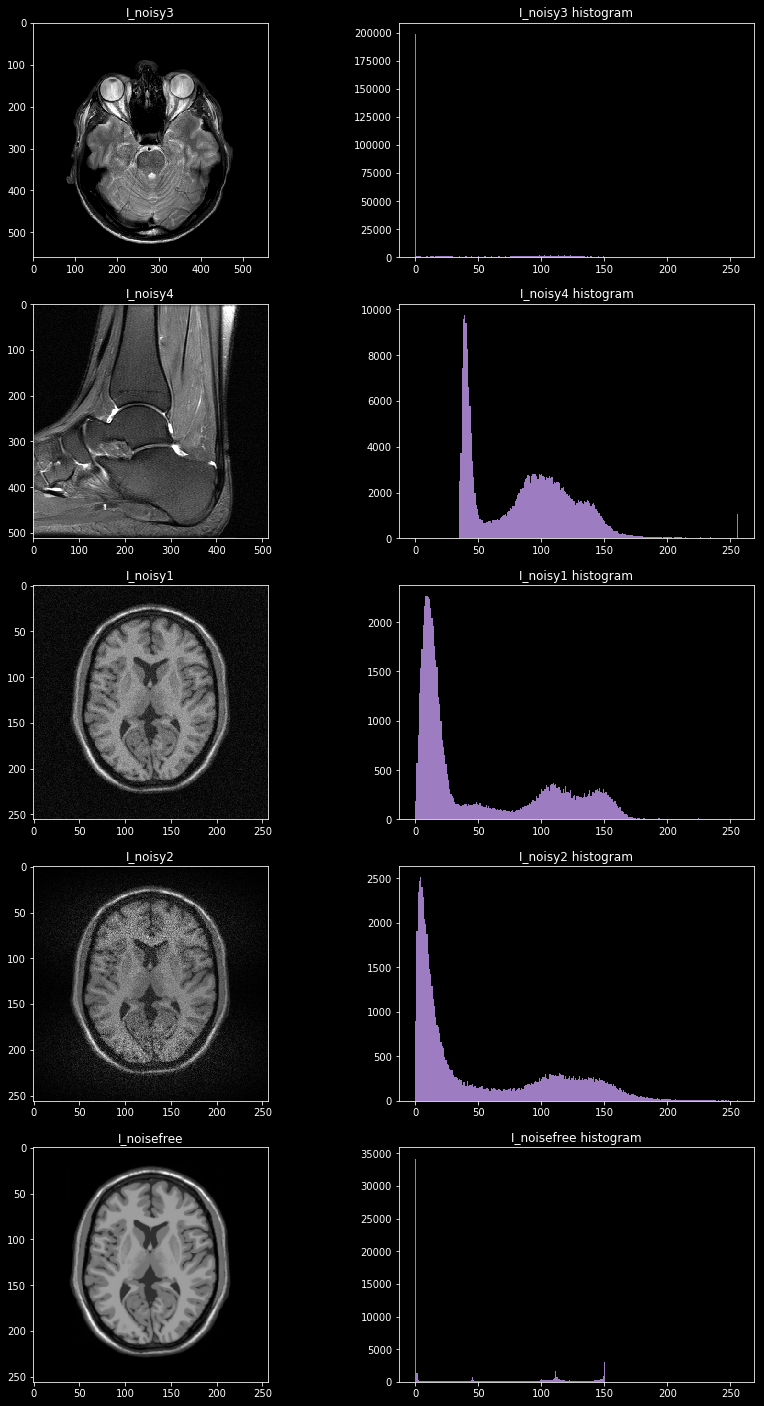

In [6]:
display_util.images_with_histograms(files_list=images, names_list=image_names)

## Auxiliary functions

### Python colfilt polyfill

In [7]:
def rolling_window(a, shape):
    s = (a.shape[0] - shape[0] + 1,) + (a.shape[1] - shape[1] + 1,) + shape
    strides = a.strides + a.strides
    return np.lib.stride_tricks.as_strided(a, shape=s, strides=strides)

In [8]:
def my_own_colfilt(data, window_shape, func):
    # acquisition of window size and image dimensions
    (window_height, window_width) = window_shape
    (data_rows, data_columns) = data.shape
    
    # preparation of memory for the returned array
    output = np.zeros(data.shape)
    
    # calculation of padding size
    vertical_padding = window_height // 2
    horizontal_padding = window_width // 2
    
    # addition of padding
    data_with_padding = np.pad(data, [(vertical_padding, vertical_padding), (horizontal_padding, horizontal_padding)], 
                               mode='constant', constant_values=0)
    
    # strides
    strides = rolling_window(data_with_padding, window_shape)
    
    for raw_inx in range(data_rows):
        for column_idx in range(data_columns):
            output[raw_inx, column_idx] = func(strides[raw_inx, column_idx])
            
    return output

### Simple convolution  polyfill

In [53]:
def simple_stride_conv2d(stride, kernel):
    return np.multiply(stride, kernel).sum()

### Gaussian filter

In [96]:
def generate_gaussian_kernel(size, mu, sigma):
    x, y = np.mgrid[-1.0:1.0:(size[1] * 1j), -1.0:1.0:(size[0] * 1j)]
    xy = np.column_stack([x.flat, y.flat])
    mu = np.array([mu, mu])
    sigma = np.array([sigma, sigma])
    covariance = np.diag(sigma**2)
    z = multivariate_normal.pdf(xy, mean=mu, cov=covariance)
    return z.reshape(x.shape)

In [188]:
# def simple_gaussian_conv(image_part):
#     image_shape = image_part.shape
#     image_part = np.float32(image_part)
#     return cv2.GaussianBlur(image_part, image_shape, 3)[image_shape[0] // 2 + 1, image_shape[1] // 2 + 1]

def simple_gaussian_conv(image_part):
    image_shape = image_part.shape
    image_part = np.float32(image_part)
    psi = generate_gaussian_kernel(image_shape, 0, 30)
    psi = psi / psi.sum()
    return simple_stride_conv2d(image_part, psi)

### Bilateral filter

In [189]:
def generate_dist_matrix(shape):
    (height, width) = shape
    mid_index = np.asarray(shape) // 2
    A = np.arange(height).reshape(height, 1)
    B = np.arange(width).reshape(1, width)
    
    A -= mid_index[0]
    B -= mid_index[1]
    
    return np.power(np.power(A, 2) + np.power(B, 2), 0.5)

In [201]:
# def bilateral_conv(image_part):
#     sigma_r = 50
#     image_shape = image_part.shape
#     image_part = np.float32(image_part)
#     dist = generate_dist_matrix(image_shape)
#     gamma = np.exp(-(np.power(get_dist_matrix(image_shape), 2))/sigma_r**2)
#     gamma = gamma / gamma.sum()
#     return simple_stride_conv2d(image_part, gamma)

def bilateral_conv(image_part):
    sigma_r = 1.5
    image_shape = image_part.shape
    image_part = np.float32(image_part)
    dist = get_dist_matrix(image_shape)
    gamma = np.exp(-(np.power(get_dist_matrix(image_shape), 2))/sigma_r**2)
    psi = generate_gaussian_kernel(image_shape, 0, 30)
    kernel = gamma * psi
    kernel = kernel/kernel.sum()
    return simple_stride_conv2d(image_part, kernel)

## Calculation

In [192]:
output_files_gauss = [my_own_colfilt(image, (9, 9), simple_gaussian_conv) for image in images]

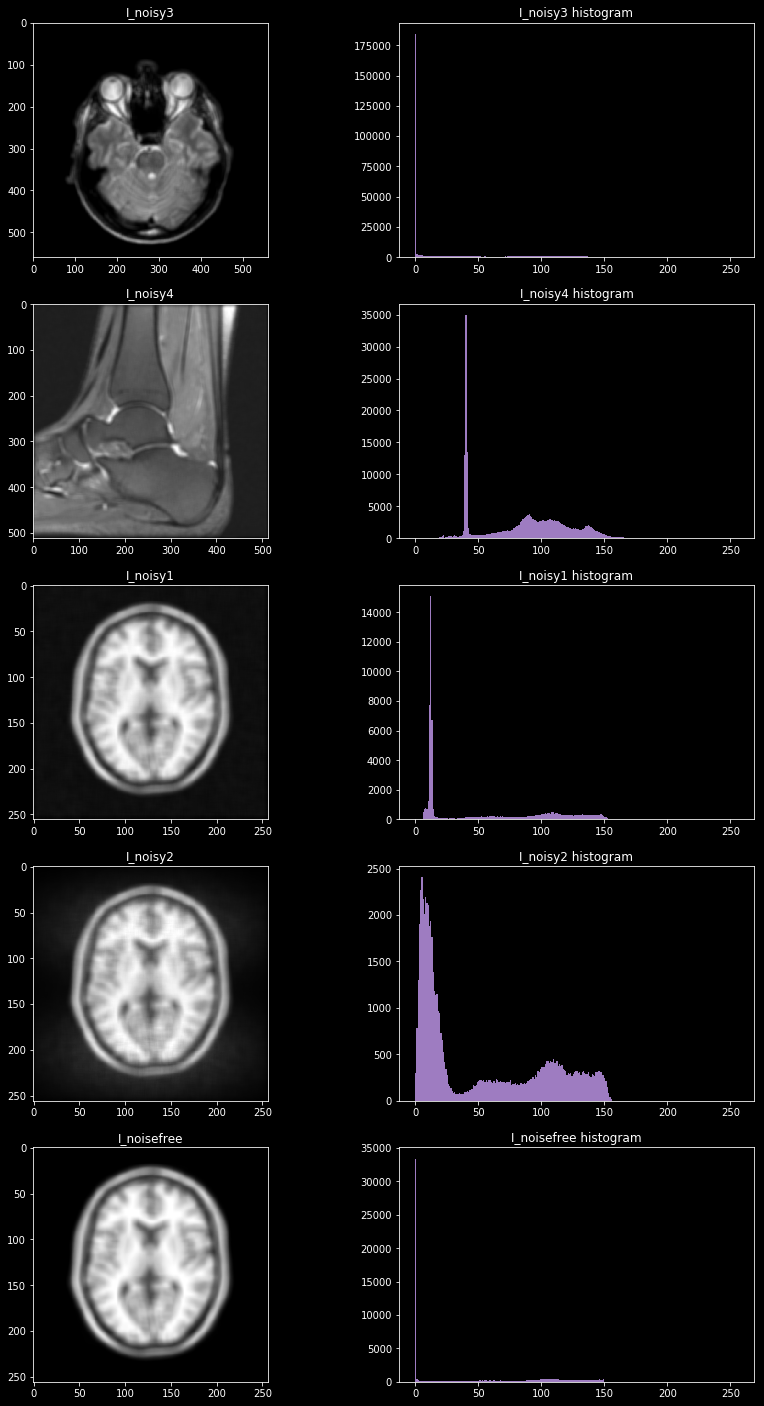

In [193]:
display_util.images_with_histograms(files_list=output_files_gauss, names_list=image_names)

In [202]:
output_files_bilateral = [my_own_colfilt(image, (9, 9), bilateral_conv) for image in images]

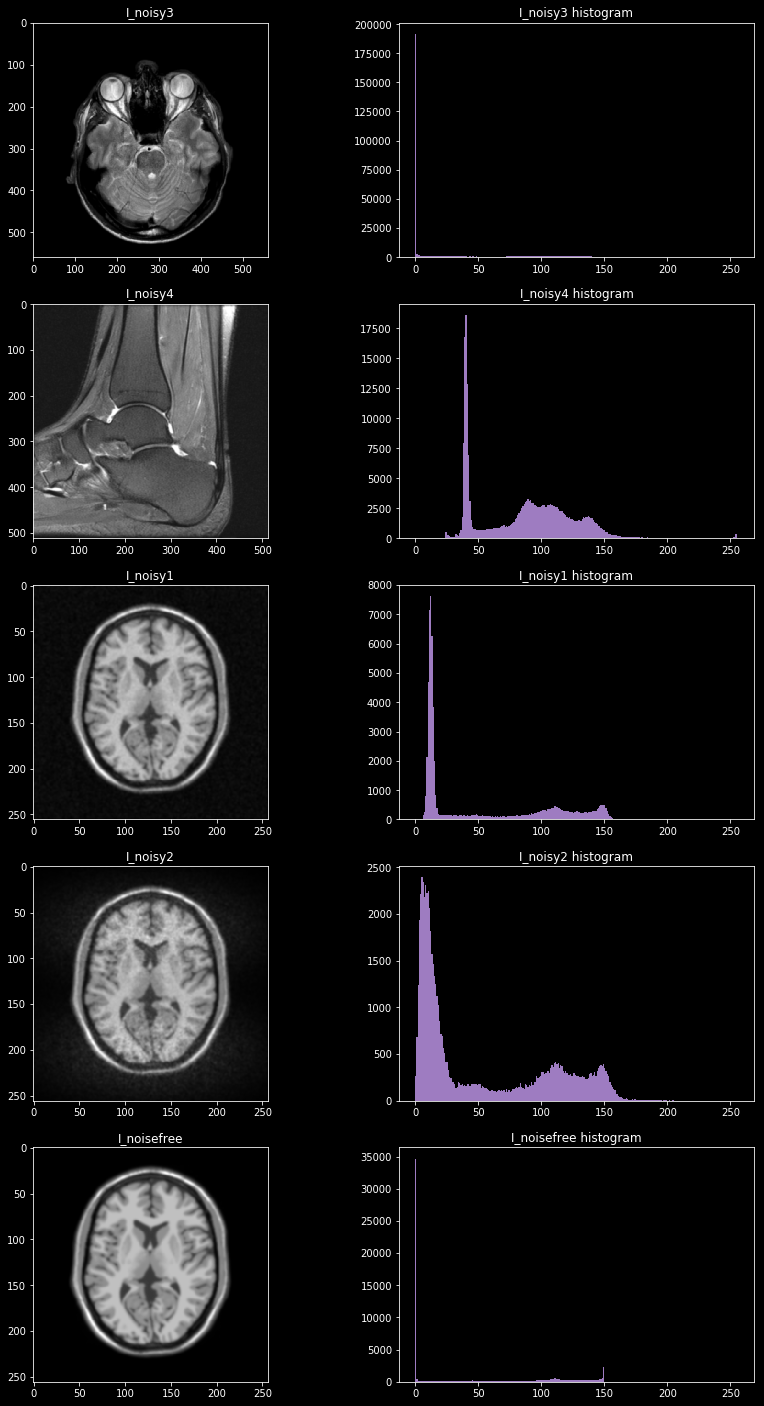

In [203]:
display_util.images_with_histograms(files_list=output_files_bilateral, names_list=image_names)

In [204]:
def compare(images_1, images_2, images_3, names_list=None, size=None):
    images_count = len(images_1)
    figsize = size if size else (12, 5 * images_count)
    names = names_list if names_list else [""] * images_count
    
    plt.style.use('dark_background')
    f, axarr = plt.subplots(images_count, 3, figsize=figsize)
    for index, (files, name) in enumerate(zip(zip(images_1, images_2, images_3), names)):
        axarr[index, 0].imshow(files[0],'gray')
        axarr[index, 0].set_title(name)
        axarr[index, 1].imshow(files[1],'gray')
        axarr[index, 1].set_title(name)
        axarr[index, 2].imshow(files[2],'gray')
        axarr[index, 2].set_title(name)
    plt.show()

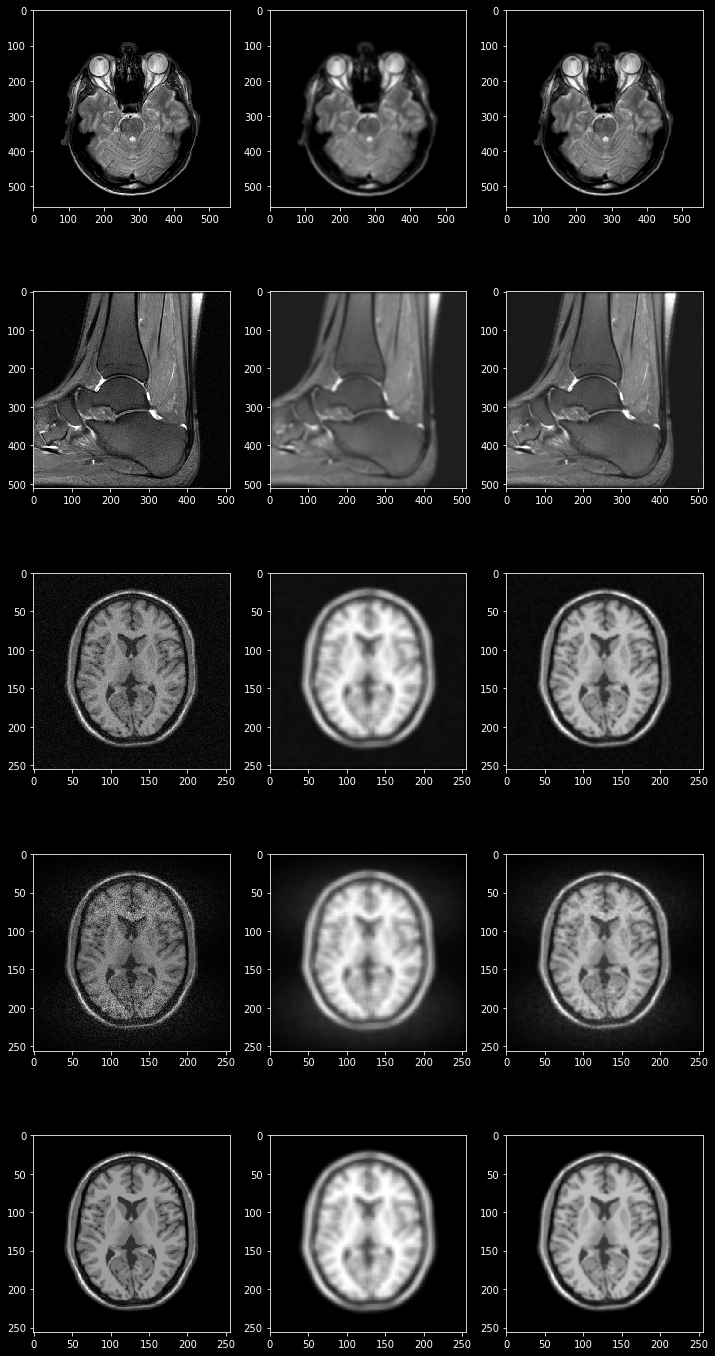

In [205]:
compare(images, output_files_gauss, output_files_bilateral)

In [207]:
premade_bilateral = [cv2.bilateralFilter(np.float32(image), 1, 30, 30) for image in images]

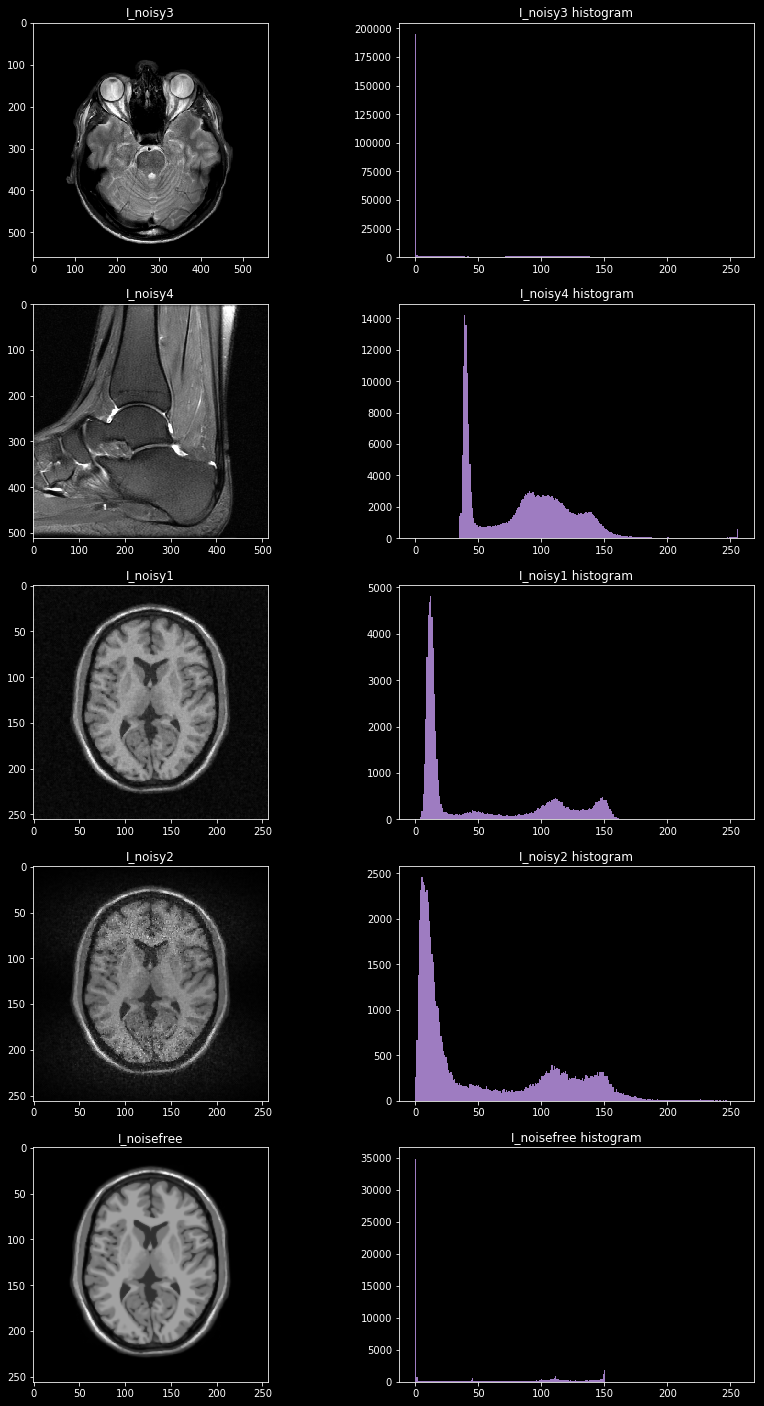

In [208]:
display_util.images_with_histograms(files_list=premade_bilateral, names_list=image_names)

## Resources

1. [Bilateral Filtering](http://eric-yuan.me/bilateral-filtering/)
2. [2D Convolution ( Image Filtering )](https://docs.opencv.org/3.1.0/d4/d13/tutorial_py_filtering.html)
3. [Image Filtering OpenCV Doc](https://docs.opencv.org/2.4/modules/imgproc/doc/filtering.html)